In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
import keras
from matplotlib.pyplot import imshow
import matplotlib.pyplot
import scipy
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19

%matplotlib inline
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
#Loading some Data from folder 
def load_girl_dataset(start, final):
    data = []
    for i in range(start,final):
        image = str(i)+".jpg"
        fname ="D:/BoyGirlUNK/girl/"+image
        img1 = Image.open(fname).convert('RGB')
        img2 = scipy.misc.imresize(img1, size=(64,64))
        data.append(img2)
    return data

def load_boy_dataset(start,final):
    data = []
    for i in range(start,final):
        image = str(i)+".jpg"
        fname ="D:/BoyGirlUNK/boy/"+image
        img1 = Image.open(fname).convert('RGB')
        img2 = scipy.misc.imresize(img1, size=(64,64))
        data.append(img2)
    return data

In [3]:
#loading the datasets needed
girl_train = load_girl_dataset(1,21)
girl_test= load_girl_dataset(21,26)
boy_train = load_boy_dataset(26,46)
boy_test = load_boy_dataset(46,51)

C:\Users\Admin\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
C:\Users\Admin\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [4]:
#Converting All part to Array 
girl_train=np.asarray(girl_train)
girl_test=np.asarray(girl_test)
boy_train=np.asarray(boy_train)
boy_test=np.asarray(boy_test)

#Checking 
print(girl_train.shape) #20 Training data,64x64 pixel,RGB
print(girl_test.shape) #5 test data,64x64 pixel,RGB
print(boy_train.shape) 
print(boy_test.shape)

(20, 64, 64, 3)
(5, 64, 64, 3)
(20, 64, 64, 3)
(5, 64, 64, 3)


In [5]:
#salt_pepper Noise for Image Augmentation
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy
  
#salt_pepper_noise_imgs = add_salt_pepper_noise(X_imgs)

In [6]:
#Girl
New_data_girl_train=add_salt_pepper_noise(girl_train)
#Boy
New_data_boy_train=add_salt_pepper_noise(boy_train)
#Stacking into array 
girl_train=np.vstack((girl_train,New_data_girl_train))

boy_train=np.vstack((boy_train,New_data_boy_train))

print(girl_train.shape)

(40, 64, 64, 3)


In [7]:
#ADD NEW DATA AUGMENTATION HERE

In [8]:
#girl
New_data_girl_train=np.fliplr(girl_train)
#boy
New_data_boy_train=np.fliplr(boy_train)

girl_train=np.vstack((girl_train,New_data_girl_train))
boy_train=np.vstack((boy_train,New_data_boy_train))

print(girl_train.shape)

(80, 64, 64, 3)


In [9]:
#Stacking X 
X_train=np.vstack((girl_train,boy_train)) 
X_test=np.vstack((girl_test,boy_test))
print(X_train.shape) #40 20 girl+20 boys stack vertically
print(X_test.shape)

(160, 64, 64, 3)
(10, 64, 64, 3)


In [10]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [11]:
#Labelling and making answer girl Y=1 , boy Y=0

#Labelling train set
Y_train_girls=np.ones((girl_train.shape[0],1),dtype=int)
Y_train_boys=np.zeros((boy_train.shape[0],1),dtype=int)

#Labelling Test set
Y_test_girls=np.ones((girl_test.shape[0],1),dtype=int)
Y_test_boys=np.zeros((boy_test.shape[0],1),dtype=int)

print(Y_train_girls.shape)
print(Y_train_boys.shape)#Train 20 Boys,20 Girls
print(Y_test_girls.shape)
print(Y_test_boys.shape)#Test 5 Boys,5 Girls

#Stack Jawaban
Y_test=np.vstack((Y_test_girls,Y_test_boys)) #Gara2 diatas distack girl dulu baru boy ini ngikutin
Y_train=np.vstack((Y_train_girls,Y_train_boys))

#Convert Y ke 1 hot
Y_train = convert_to_one_hot(Y_train, 2).T
Y_test = convert_to_one_hot(Y_test,2).T

print(Y_test.shape)
print(Y_train.shape)

(80, 1)
(80, 1)
(5, 1)
(5, 1)
(10, 2)
(160, 2)



y= [1. 0.]


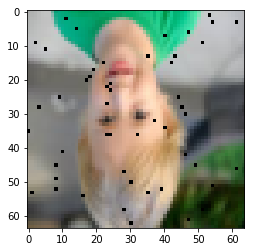

In [12]:
# Example of a picture
index =140
plt.imshow(X_train[index])
print("\ny= "+str(Y_train[index]))

In [13]:
#Normalize input
#Supaya inputnya 0-1
X_train = X_train / 255
X_test = X_test / 255

In [14]:
def boygirlModel(input_shape):
    #define the input image
    X_input = Input(input_shape)
    #pad X_input with zeroes
    VGG19(weights='imagenet')
    X = ZeroPadding2D((3,3))(X_input)
    #layer group 1 32*32*32
    #CONV->BN->RELU block applied to X
    X = Conv2D(32, (7,7), strides = (1,1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name= 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name = 'max_pool1')(X)
    #layer group 2 16*16*64
    #CONV->BN->RELU block applied to X
    X = ZeroPadding2D((2,2))(X)
    X = Conv2D(64, (5,5), strides = (1,1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name = 'max_pool2')(X)
    #layer group 3 8*8*128
    #CONV->BN->RELU block applied to X
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(128, (3,3), strides = (1,1), name = 'conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name = 'max_pool3')(X)
    #layer group 4 8*8*64
    #CONV->BN->RELU block applied to X
    X = Conv2D(64, (1,1), strides = (1,1), name = 'conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    #layer group 5 4*4*32
    #CONV->BN->RELU block applied to X
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(32,(3,3), strides = (1,1), name= 'conv5')(X)
    X = BatchNormalization(axis = 3, name = 'bn5')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), name = 'max_pool5')(X)
    #Flatten X + Fully connected layers
    X = Flatten()(X)
    X = Dense(128, activation='sigmoid', name = 'fc1')(X)
    X = Dense(32, activation='sigmoid', name = 'fc2')(X)
    X = Dense(2, activation= 'softmax', name = 'fc3')(X)
    #create model
    model = Model(inputs = X_input, outputs = X, name = 'boygirlModel')
    
    return model


In [ ]:
boygirlModel = boygirlModel((64,64,3))

In [ ]:
boygirlModel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
boygirlModel.fit(x = X_train, y = Y_train, epochs = 20, batch_size = 16)

In [ ]:
preds = boygirlModel.evaluate(x=X_test,y=Y_test)

print('accuracy = '+str(preds[1]*100))
print('loss = '+str(preds[0]))

print(preds[1])

In [ ]:
preds = boygirlModel.evaluate(x=X_train,y=Y_train)

print('accuracy = '+str(preds[1]*100))
print('loss = '+str(preds[0]))
print(preds)

In [ ]:
boygirlModel.summary()

In [ ]:
#test With ur own 
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

#Preprocces Image
img_path="C:/Users/Admin/Desktop/kel.jpg"
img=image.load_img(img_path,target_size=(64,64))
imshow(img)

# x=image.img_to_array(img)
# x=np.expand_dims(x,axis = 0)
# x=preprocess_input(x)

# #show predictions
# print("Your prediction=" + catdogModel.predict(x))

# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
boygirlModel.predict(images)